# **0. Setup**

## 0.1. Library and Environment

In [ ]:
!pip -U install pandas matplotlib yfinance seaborn plotly alpha_vantage python-dotenv nbformat statsmodels scikit-learn

In [11]:
import os
import re
import math
import numpy as np
import pandas as pd
from dotenv import load_dotenv # type: ignore

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats

np.random.seed(42)
pd.set_option("display.max_columns", None)

FIG_DIR = "fig"
TICKER = "^GSPC"
START_DATE = "1900-01-01"
END_DATE = "2025-01-01"
INTERVAL = "1D"

load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY_2")

MACRO_ECONOMICS_INDICATORS = ["VIXY", "IEF", "UUP", "USO", "GLD", "CPI"]


## 0.2. Data Crawling

### 0.2.1. OHLCV

In [ ]:
raw_data = yf.download(
    tickers = TICKER,
    start = START_DATE,
    end = END_DATE,
    interval = INTERVAL,
    progress = False,
    auto_adjust = True
)

def col_preprocess(df):
    df_tmp = df.copy()
    df_tmp.columns = df_tmp.columns.get_level_values(0)
    df_tmp = df_tmp[['Open', 'High', 'Low', 'Close', 'Volume']]
    df_tmp.reset_index(inplace=True)
    df_tmp.columns.name = None
    df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])
    return df_tmp

ohlcv = col_preprocess(raw_data)
ohlcv.to_csv("data/GSPC.csv", index=False)
print(f"Downloaded {TICKER}")

Downloaded ^GSPC


### 0.2.2. Macroeconomics

In [42]:
def get_indicator(symbol, start, end):
    ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
    data, meta = ts.get_daily(symbol=symbol, outputsize='full')
    data = data.rename(columns={'1. open': 'Open'})
    data = data.rename(columns={'2. high': 'High'})
    data = data.rename(columns={'3. low': 'Low'})
    data = data.rename(columns={'4. close': 'Close'})
    data = data.rename(columns={'5. volume': 'Volume'})
    data.index = pd.to_datetime(data.index)
    data = data.loc[(data.index >= start) & (data.index <= end)]

    data = data.sort_index(ascending=True)
    data = data.reset_index()
    if 'index' in data.columns:
        data = data.rename(columns={'index': 'Date'})
    elif 'date' in data.columns:
        data = data.rename(columns={'date': 'Date'})
    else:
        data['Date'] = data.index

    return data

for sym in MACRO_ECONOMICS_INDICATORS:
    try:
        ind = get_indicator(sym, START_DATE, END_DATE)
        ind.to_csv(f"data/{sym}.csv", index=False)
        print(f"Downloaded {sym}")
    except Exception as e:
        print(f"Error when download {sym}: {e}")

Downloaded VIXY
Downloaded IEF
Error when download UUP: Response ended prematurely
Downloaded USO
Downloaded GLD
Downloaded CPI


### 0.2.3. Merging

In [54]:
GSPC = pd.read_csv("data/GSPC.csv", index_col="Date")
CPI = pd.read_csv("data/CPI.csv", index_col="Date")
GLD = pd.read_csv("data/GLD.csv", index_col="Date")
IEF = pd.read_csv("data/IEF.csv", index_col="Date")
USO = pd.read_csv("data/USO.csv", index_col="Date")
UUP = pd.read_csv("data/UUP.csv", index_col="Date")
VIXY = pd.read_csv("data/VIXY.csv", index_col="Date")

dfs = {
    "CPI": CPI,
    "GLD": GLD,
    "IEF": IEF,
    "USO": USO,
    "UUP": UUP,
    "VIXY": VIXY
}

for name, df in dfs.items():
    df_close = df[['Close']].rename(columns={'Close': name})
    GSPC = GSPC.merge(df_close, left_index=True, right_index=True, how='outer')

GSPC.to_csv("data/merged.csv", index="Date")

# **1. EDA**

In [80]:
data = pd.read_csv("data/merged.csv", index_col="Date")
data

,Open,High,Low,Close,Volume,CPI,GLD,IEF,USO,UUP,VIXY
Date,,,,,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,5984.629883,6040.100098,5981.439941,6040.040039,1757720000,NaN,241.44,92.25,73.65,29.37,41.56
2024-12-26,6024.970215,6049.750000,6007.370117,6037.589844,2904530000,NaN,243.07,92.32,73.13,29.31,41.81
2024-12-27,6006.169922,6006.169922,5932.950195,5970.839844,3159610000,NaN,241.40,92.08,73.85,29.26,43.81


## a. Data Summary

In [81]:
def summarize_data(df):
    print(f"Data info:")
    print(f"{df.info()}\n")

    print(f"Zero value check: \n{(df == 0).sum()}\n")

    print(f"Null value check: \n{df.isna().sum()}\n")

    duplicate_count = df.duplicated().sum()
    print(f"Duplicate rows: {duplicate_count}")
    if duplicate_count != 0:
        duplicates = df[df.duplicated()]
        print(duplicates)

summarize_data(data)

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 24367 entries, 1927-12-30 to 2024-12-31
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    24367 non-null  float64
 1   High    24367 non-null  float64
 2   Low     24367 non-null  float64
 3   Close   24367 non-null  float64
 4   Volume  24367 non-null  int64  
 5   CPI     3556 non-null   float64
 6   GLD     5063 non-null   float64
 7   IEF     5647 non-null   float64
 8   USO     4714 non-null   float64
 9   UUP     4491 non-null   float64
 10  VIXY    3521 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 2.2+ MB
None

Zero value check: 
Open         0
High         0
Low          0
Close        0
Volume    5497
CPI          0
GLD          0
IEF          0
USO          0
UUP          0
VIXY         0
dtype: int64

Null value check: 
Open          0
High          0
Low           0
Close         0
Volume        0
CPI       20811
GLD       19304
IEF

## b. Preprocessing

In [ ]:
first_valid_index = data.dropna().index.min()
last_valid_index = data.dropna().index.max()
cropped_data = data.loc[first_valid_index:last_valid_index].reset_index()
cropped_data.to_csv("data/cropped.csv", index=False)
summarize_data(cropped_data)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3257 non-null   object 
 1   Open    3257 non-null   float64
 2   High    3257 non-null   float64
 3   Low     3257 non-null   float64
 4   Close   3257 non-null   float64
 5   Volume  3257 non-null   int64  
 6   CPI     3257 non-null   float64
 7   GLD     3257 non-null   float64
 8   IEF     3257 non-null   float64
 9   USO     3257 non-null   float64
 10  UUP     3257 non-null   float64
 11  VIXY    3257 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 305.5+ KB
None

Zero value check: 
Date      0
Open      0
High      0
Low       0
Close     0
Volume    1
CPI       0
GLD       0
IEF       0
USO       0
UUP       0
VIXY      0
dtype: int64

Null value check: 
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
CPI       0
GLD       0
I

## c. Statistical Analysis

In [119]:
data = pd.read_csv("data/cropped.csv", index_col="Date")
data.index = pd.to_datetime(data.index)

def statistical_analysis(df: pd.DataFrame) -> dict:
    result = {
        "mean": df.mean(),
        "median": df.median(),
        "std": df.std(),
        "min": df.min(),
        "max": df.max(),
        "q1": df.quantile(0.25),
        "q3": df.quantile(0.75),
        "iqr": df.quantile(0.75) - df.quantile(0.25)
    }

    return result

stats_summary = pd.DataFrame({
    col: statistical_analysis(data[col])
    for col in data.select_dtypes(include=['number']).columns
})
stats_summary = stats_summary.round(3)

stats_summary.to_csv("data/statistical_summary.csv", index="Date")
stats_summary.T.to_csv("data/statistical_summary_T.csv", index="Date")
stats_summary

,Open,High,Low,Close,Volume,CPI,GLD,IEF,USO,UUP,VIXY
mean,2634.749,2649.095,2619.422,2635.274,3.890499e+09,26.661,142.763,106.222,31.879,24.727,25.921
median,2429.200,2439.270,2413.540,2429.010,3.735980e+09,26.670,137.970,105.800,32.120,24.930,21.240
std,1029.353,1035.696,1022.738,1029.480,9.283144e+08,0.860,24.546,6.886,20.762,2.226,17.384
min,1097.420,1125.120,1074.770,1099.230,0.000000e+00,23.920,100.500,88.950,2.130,20.930,5.250
max,4804.510,4818.620,4780.040,4796.560,9.976520e+09,28.520,193.890,123.060,91.990,30.670,121.950
q1,1861.460,1873.340,1849.690,1862.490,3.336880e+09,26.108,120.780,102.140,12.280,22.548,14.620
q3,3380.860,3399.540,3366.150,3383.540,4.253920e+09,27.399,166.390,109.990,39.390,26.070,29.970
iqr,1519.400,1526.200,1516.460,1521.050,9.170400e+08,1.290,45.610,7.850,27.110,3.523,15.350


## d. Visualization

### c.1. Candlestick Chart

In [95]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ),
    secondary_y=True
)

fig.add_trace(
    go.Bar(
        x=data.index,
        y=data['Volume'],
        name='Volume',
        marker_color='blue',
        opacity=0.4
    ),
    secondary_y=False
)

fig.update_yaxes(showgrid=False, secondary_y=True)
fig.update_layout(
    title='S&P 500',
    xaxis_title='Date',
    yaxis_title='Volume',
    yaxis2_title='Index',
    xaxis_rangeslider_visible=False,
    template='seaborn',
    width=2000,
    height=1000,
)

fig.show()

### c.2. Boxplot

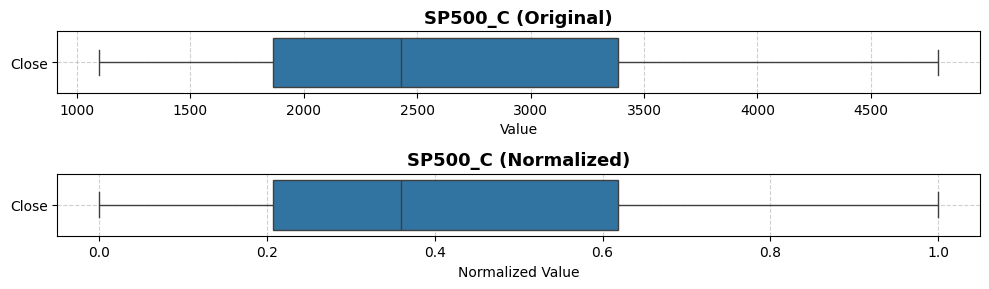

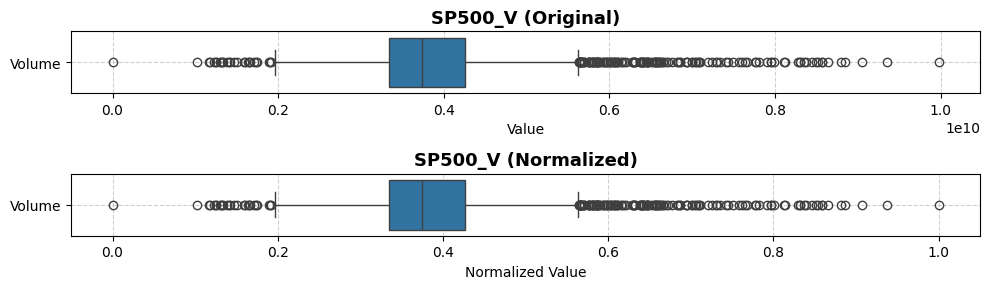

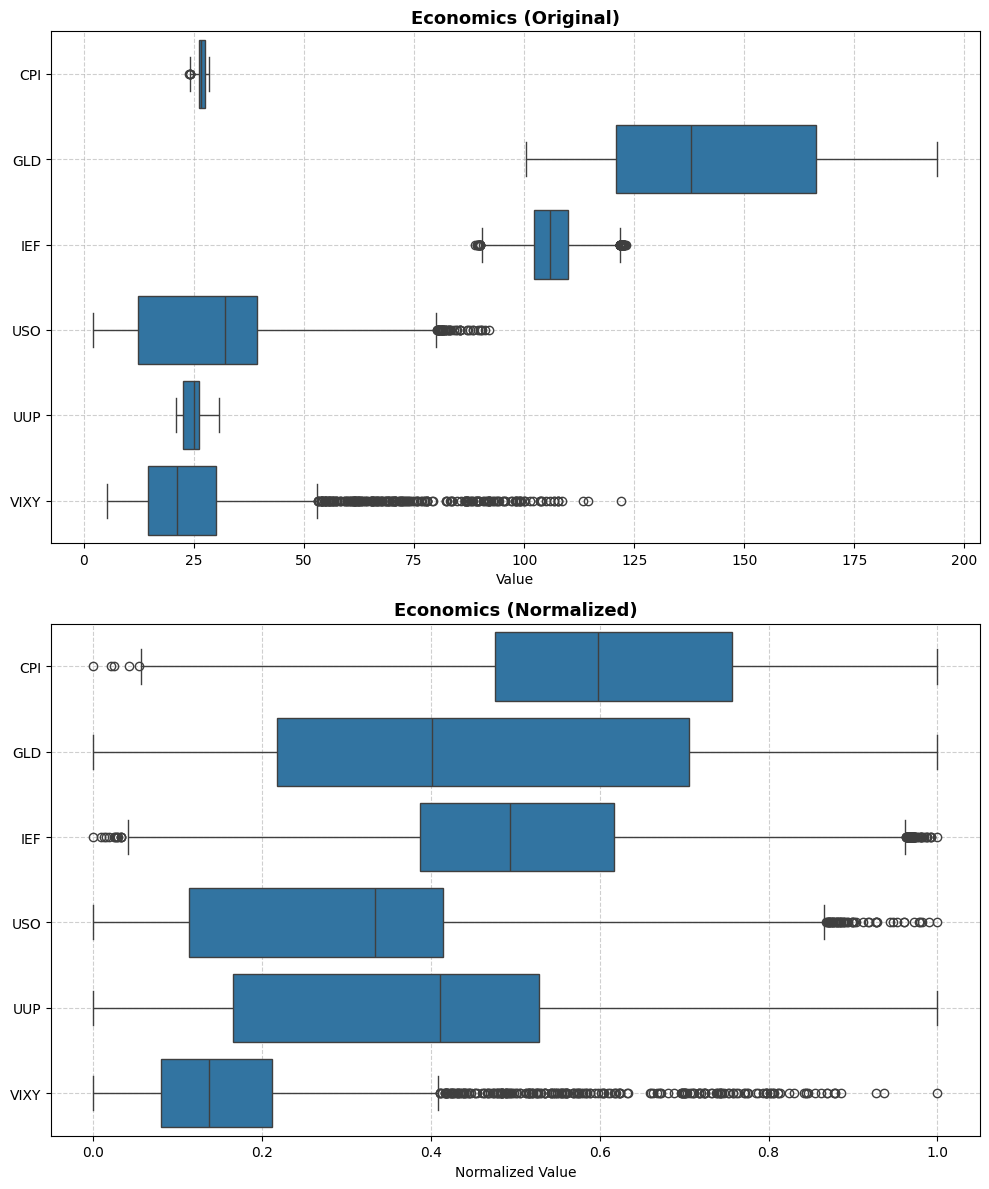

In [101]:
groups = {
    "SP500_C": ["Close"],
    "SP500_V": ["Volume"],
    'Economics': ['CPI', 'GLD', 'IEF', 'USO', 'UUP', 'VIXY'],
}
for title, cols_in_group in groups.items():
    if len(cols_in_group) == 1:
        w = 3
    else:
        w = 2 * len(cols_in_group)
    fig, axes = plt.subplots(2, 1, figsize=(10, w))

    # --- Original Data ---
    data_melted = data.melt(
        value_vars=cols_in_group,
        var_name="Value Type",
        value_name="Value"
    )
    sns.boxplot(
        y="Value Type",  # vì orient='h'
        x="Value",
        data=data_melted,
        order=cols_in_group,
        ax=axes[0],
        orient='h'
    )
    axes[0].set_title(f"{title} (Original)", fontsize=13, fontweight='bold')
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("")
    axes[0].grid(True, linestyle="--", alpha=0.6)

    # --- Normalized Data ---
    scaler = MinMaxScaler()
    data_norm = pd.DataFrame(
        scaler.fit_transform(data[cols_in_group]),
        columns=cols_in_group,
        index=data.index
    )
    data_norm_melted = data_norm.melt(
        value_vars=cols_in_group,
        var_name="Value Type",
        value_name="Value"
    )
    sns.boxplot(
        y="Value Type",
        x="Value",
        data=data_norm_melted,
        order=cols_in_group,
        ax=axes[1],
        orient='h'
    )
    axes[1].set_title(f"{title} (Normalized)", fontsize=13, fontweight='bold')
    axes[1].set_xlabel("Normalized Value")
    axes[1].set_ylabel("")
    axes[1].grid(True, linestyle="--", alpha=0.6)

    # --- Layout & Save ---
    plt.tight_layout()
    save_path = os.path.join(FIG_DIR, f"boxplot_{title.replace(' ', '_')}_compare.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()

### c.3. Histogram

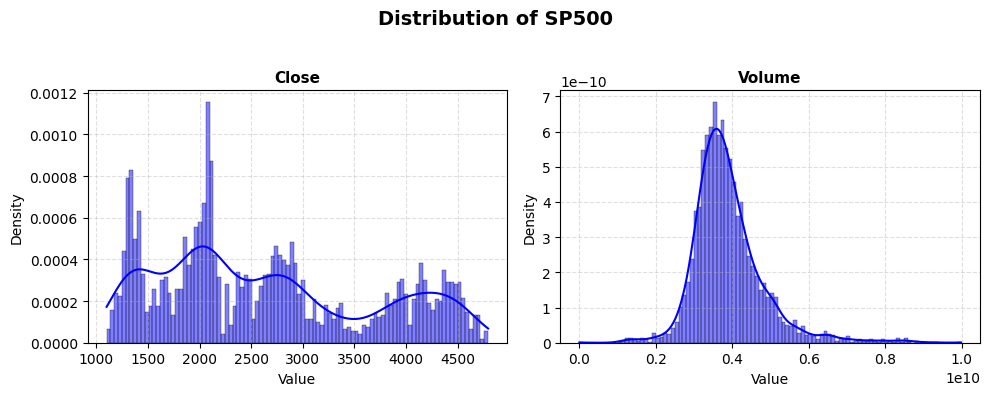

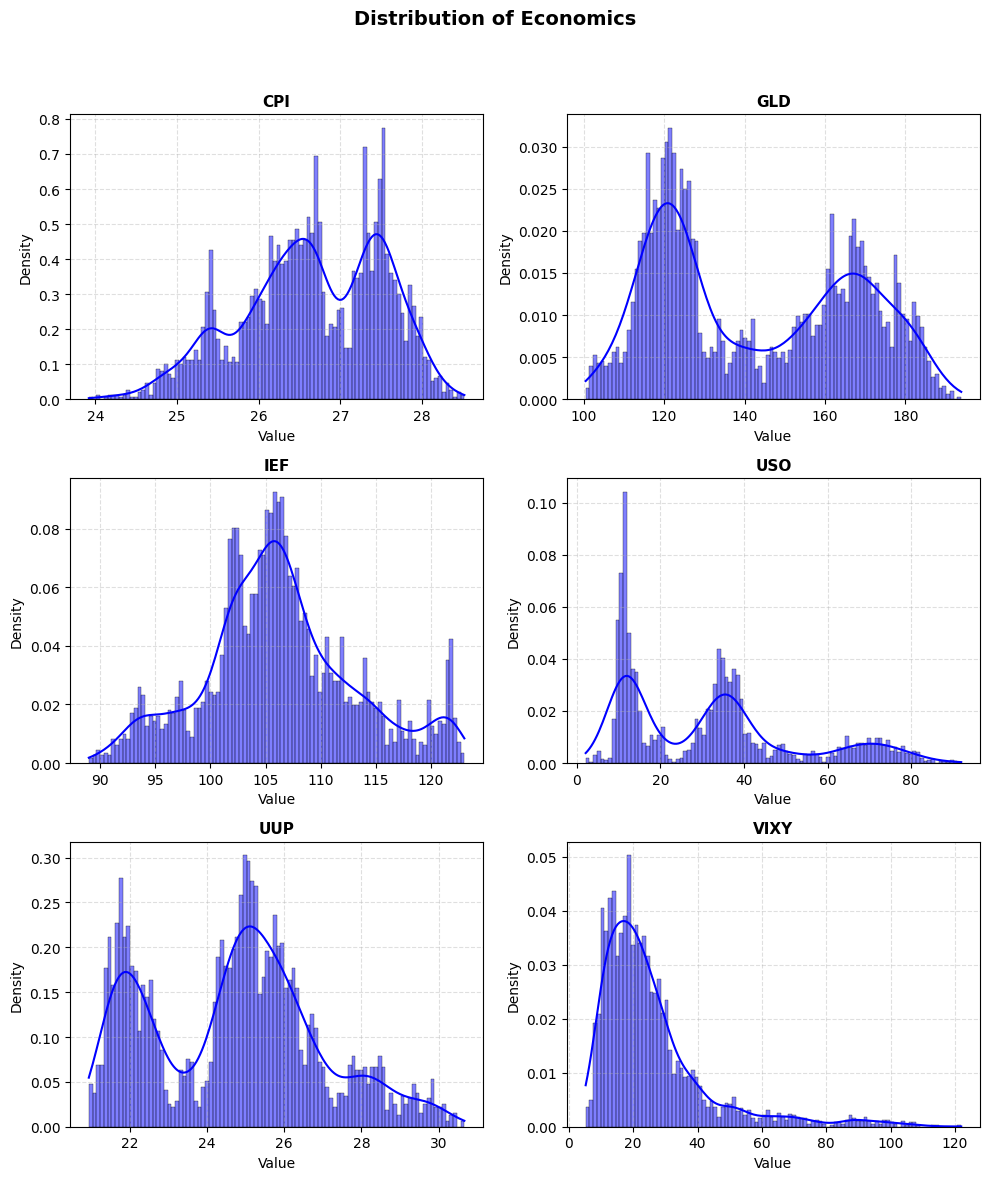

In [106]:
groups = {
    "SP500": ["Close", "Volume"],
    'Economics': ['CPI', 'GLD', 'IEF', 'USO', 'UUP', 'VIXY'],
}

max_cols = 2
        
for title, cols_in_group in groups.items():
    n = len(cols_in_group)
    n_rows = math.ceil(n / max_cols)

    fig, axes = plt.subplots(n_rows, max_cols, figsize=(5*max_cols, 4*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols_in_group):
        sns.histplot(
            data[col].dropna(),
            kde=True,
            stat="density",
            bins=100,
            color="blue",
            ax=axes[i]
        )
        axes[i].set_title(f"{col}", fontsize=11, fontweight='bold')
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Density")
        axes[i].grid(True, linestyle="--", alpha=0.4)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"Distribution of {title}", fontsize=14, fontweight='bold')
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    save_path = os.path.join(FIG_DIR, f"group_hist_{title.replace(' ', '_')}.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()

### c.4. Line Chart

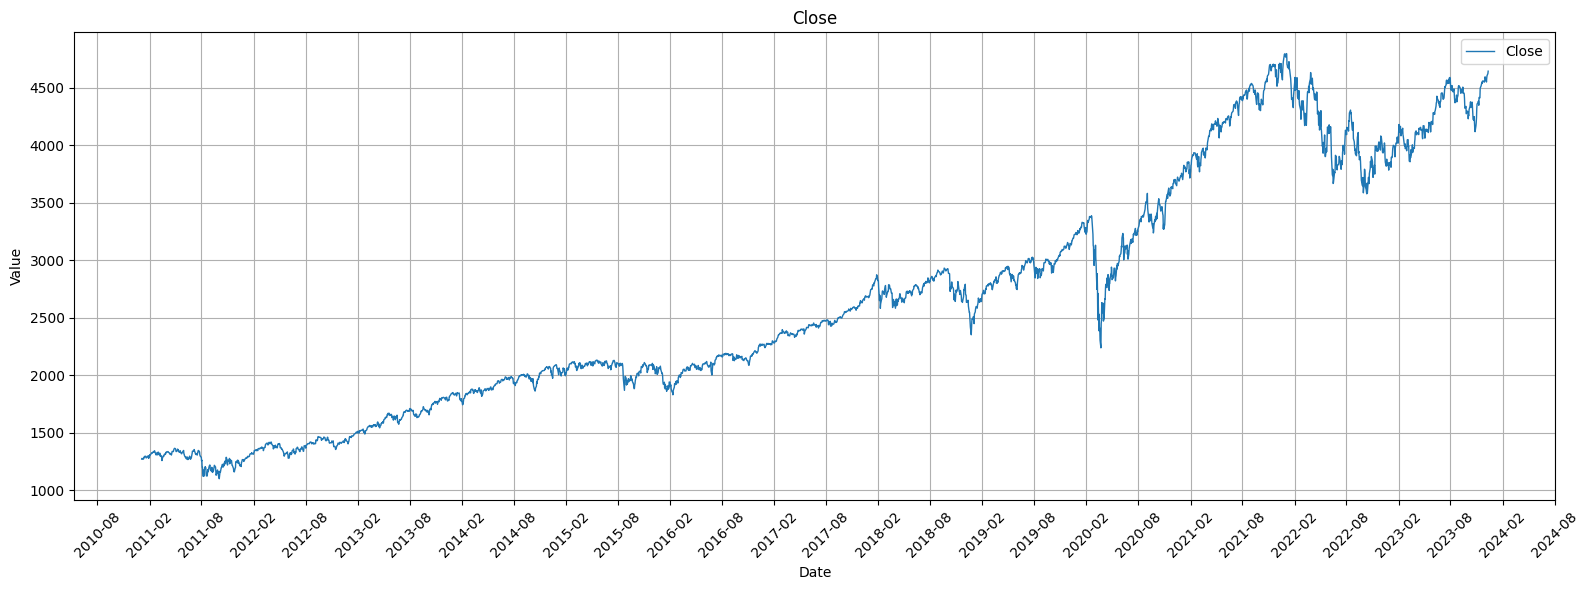

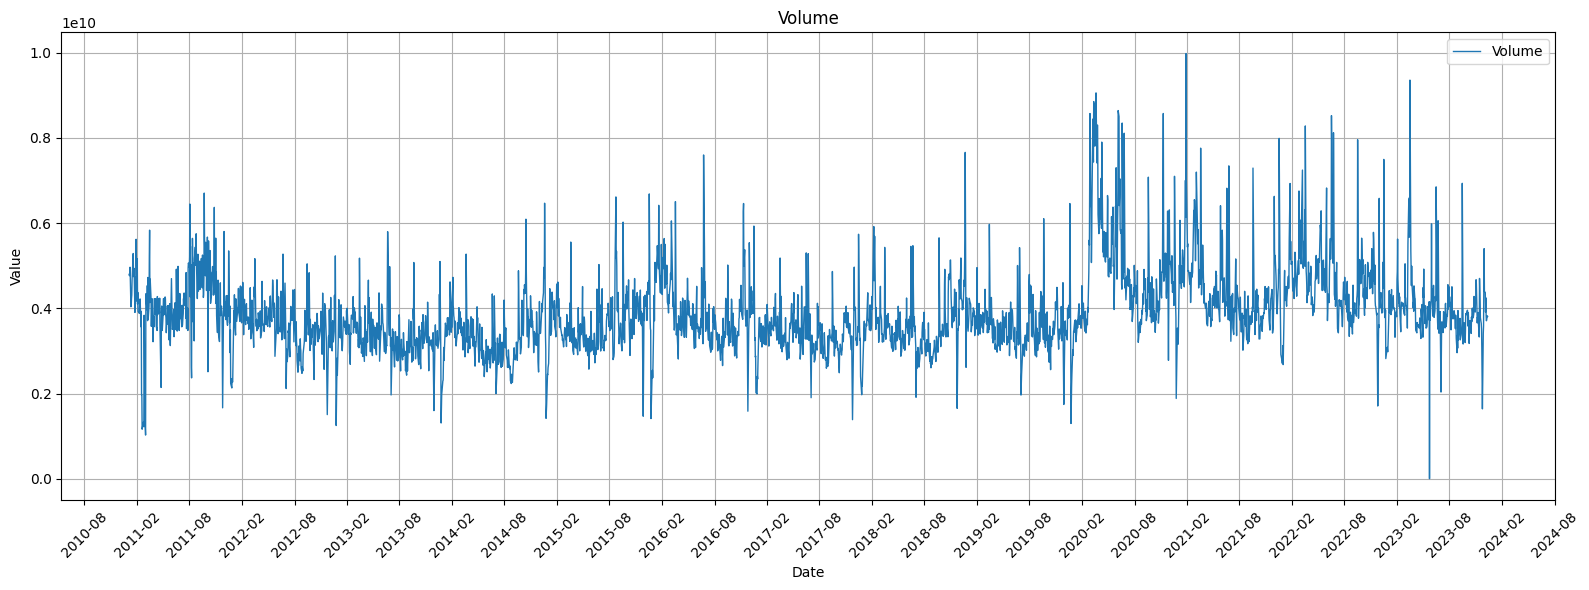

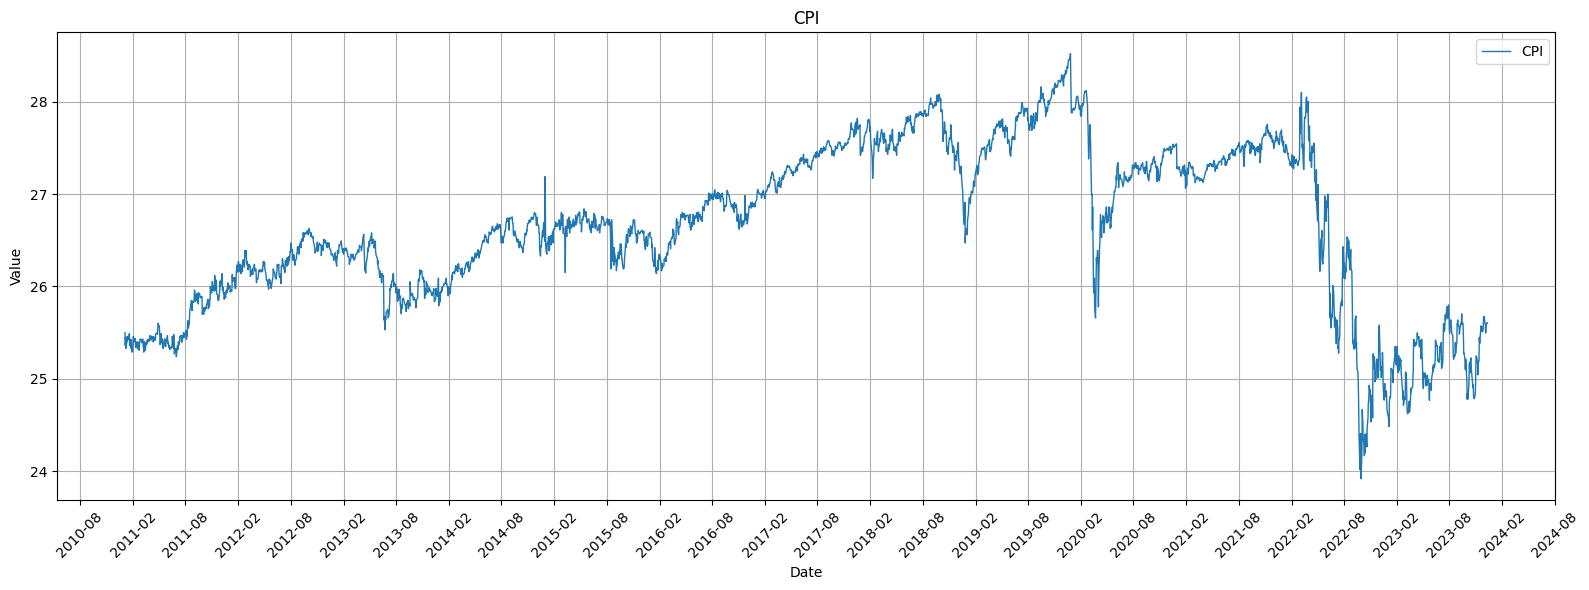

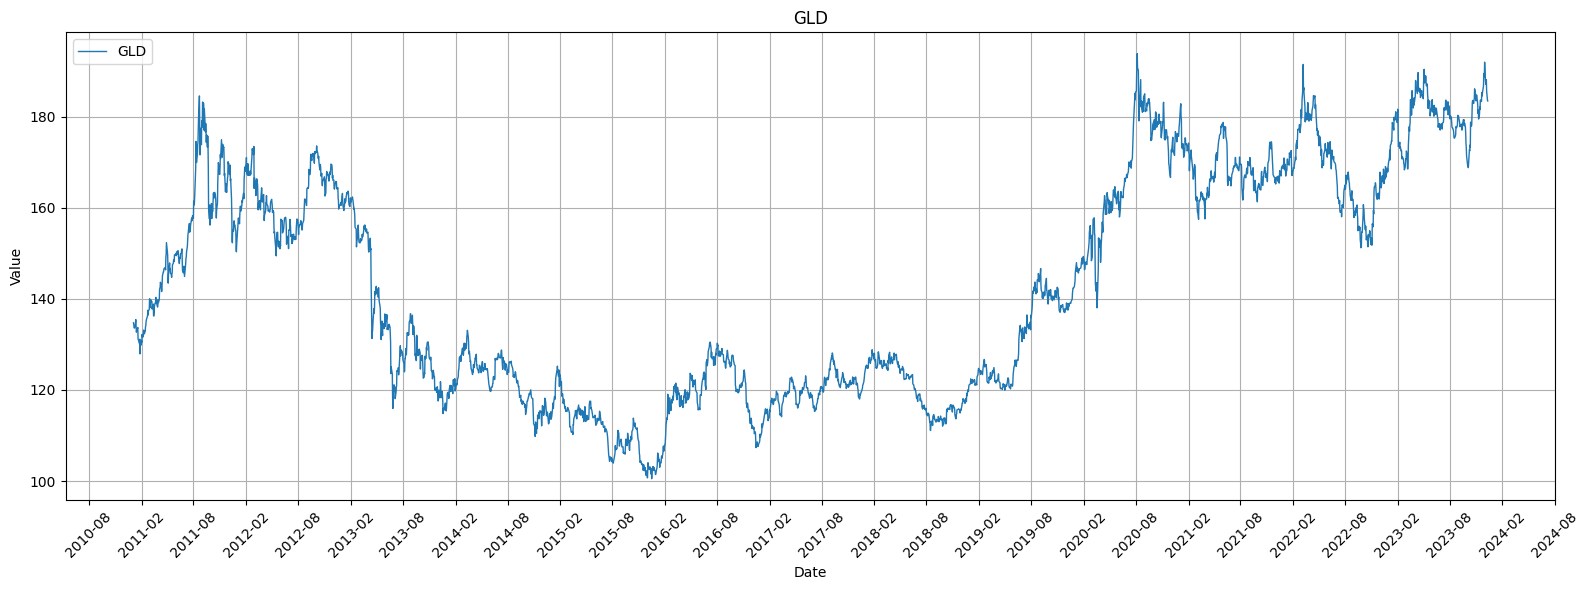

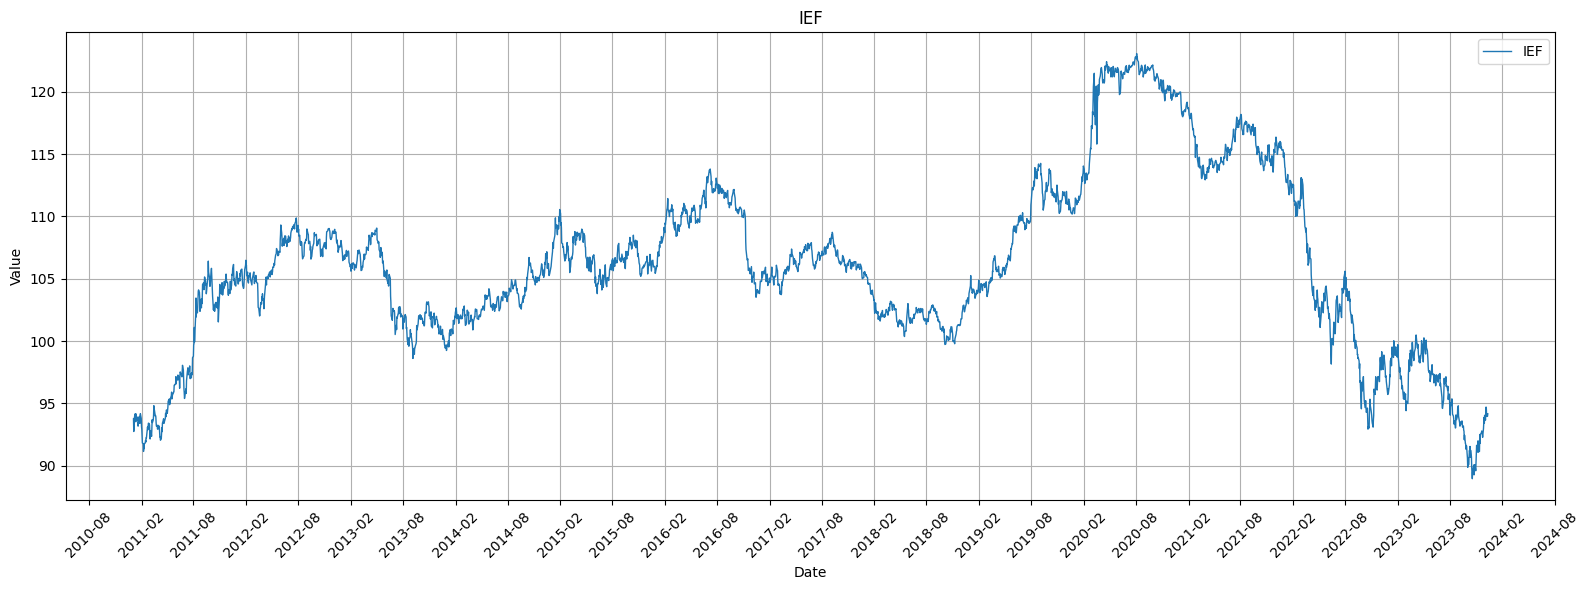

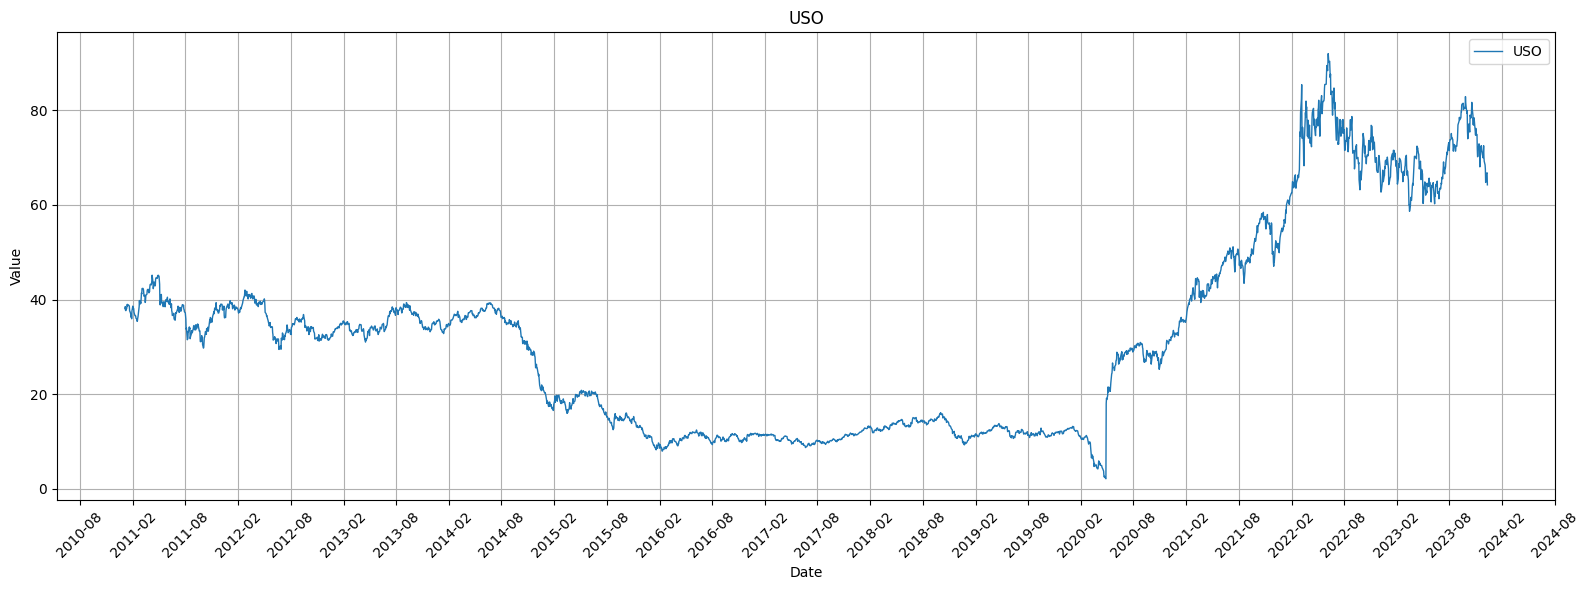

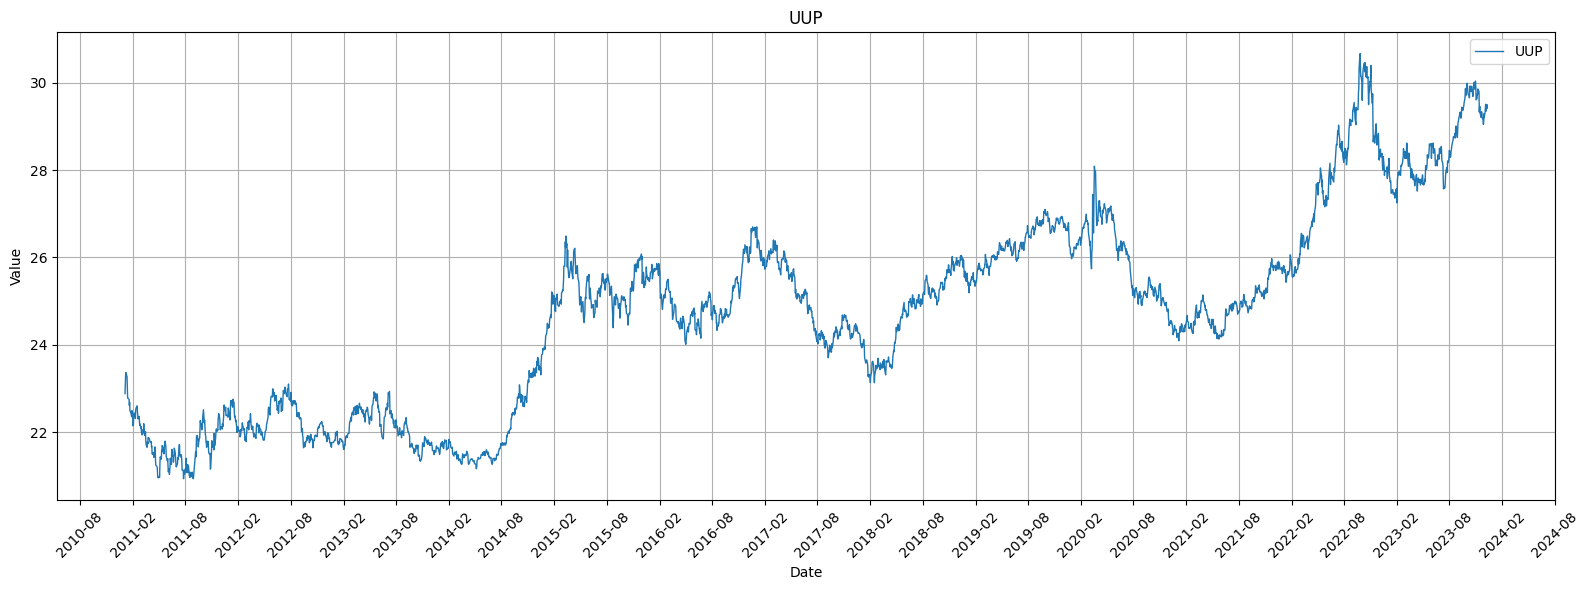

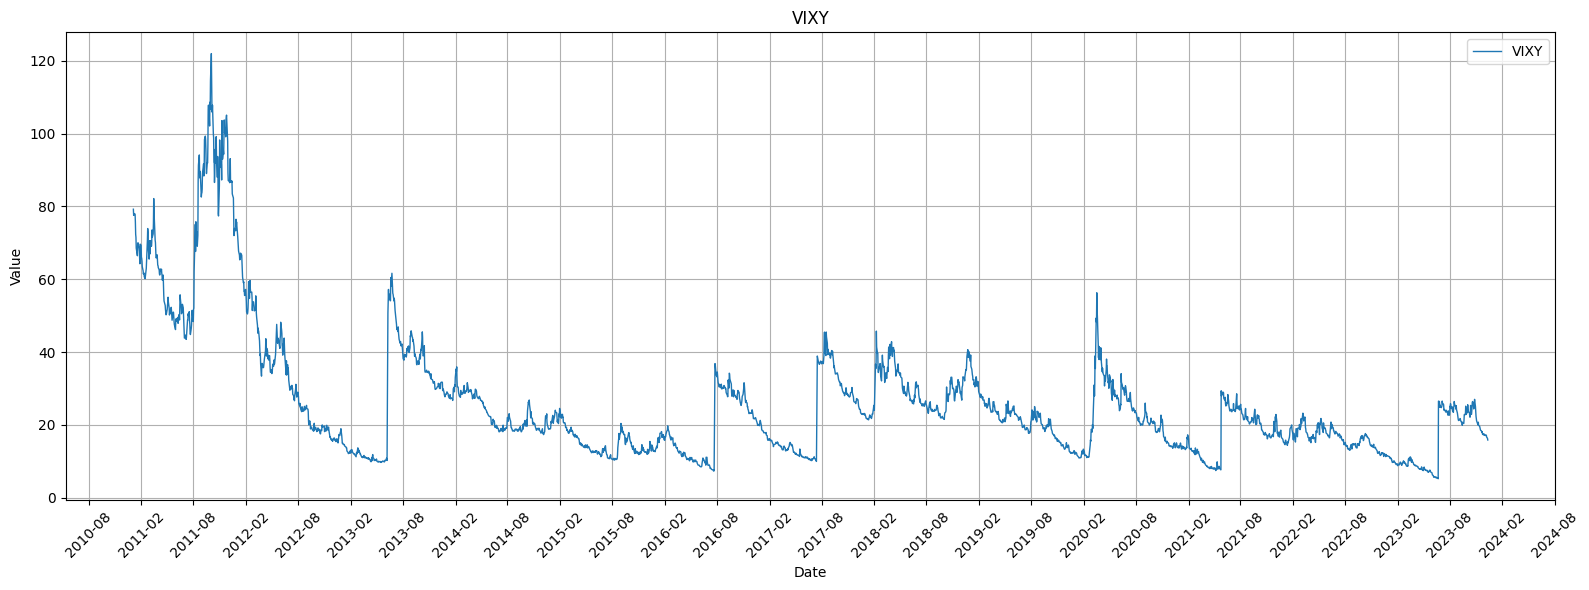

In [120]:
for title, cols_in_group in groups.items():
    for col in cols_in_group:
        plt.figure(figsize=(16,6))
        plt.plot(data.index, data[col], label=f"{col}", linewidth=1)

        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=45)

        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.title(col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        line_path = os.path.join(FIG_DIR, f"line_{col}.png")
        plt.savefig(line_path, dpi=150)
        plt.show()
        plt.close()


In [123]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'CPI', 'GLD', 'IEF', 'USO',
       'UUP', 'VIXY'],
      dtype='object')

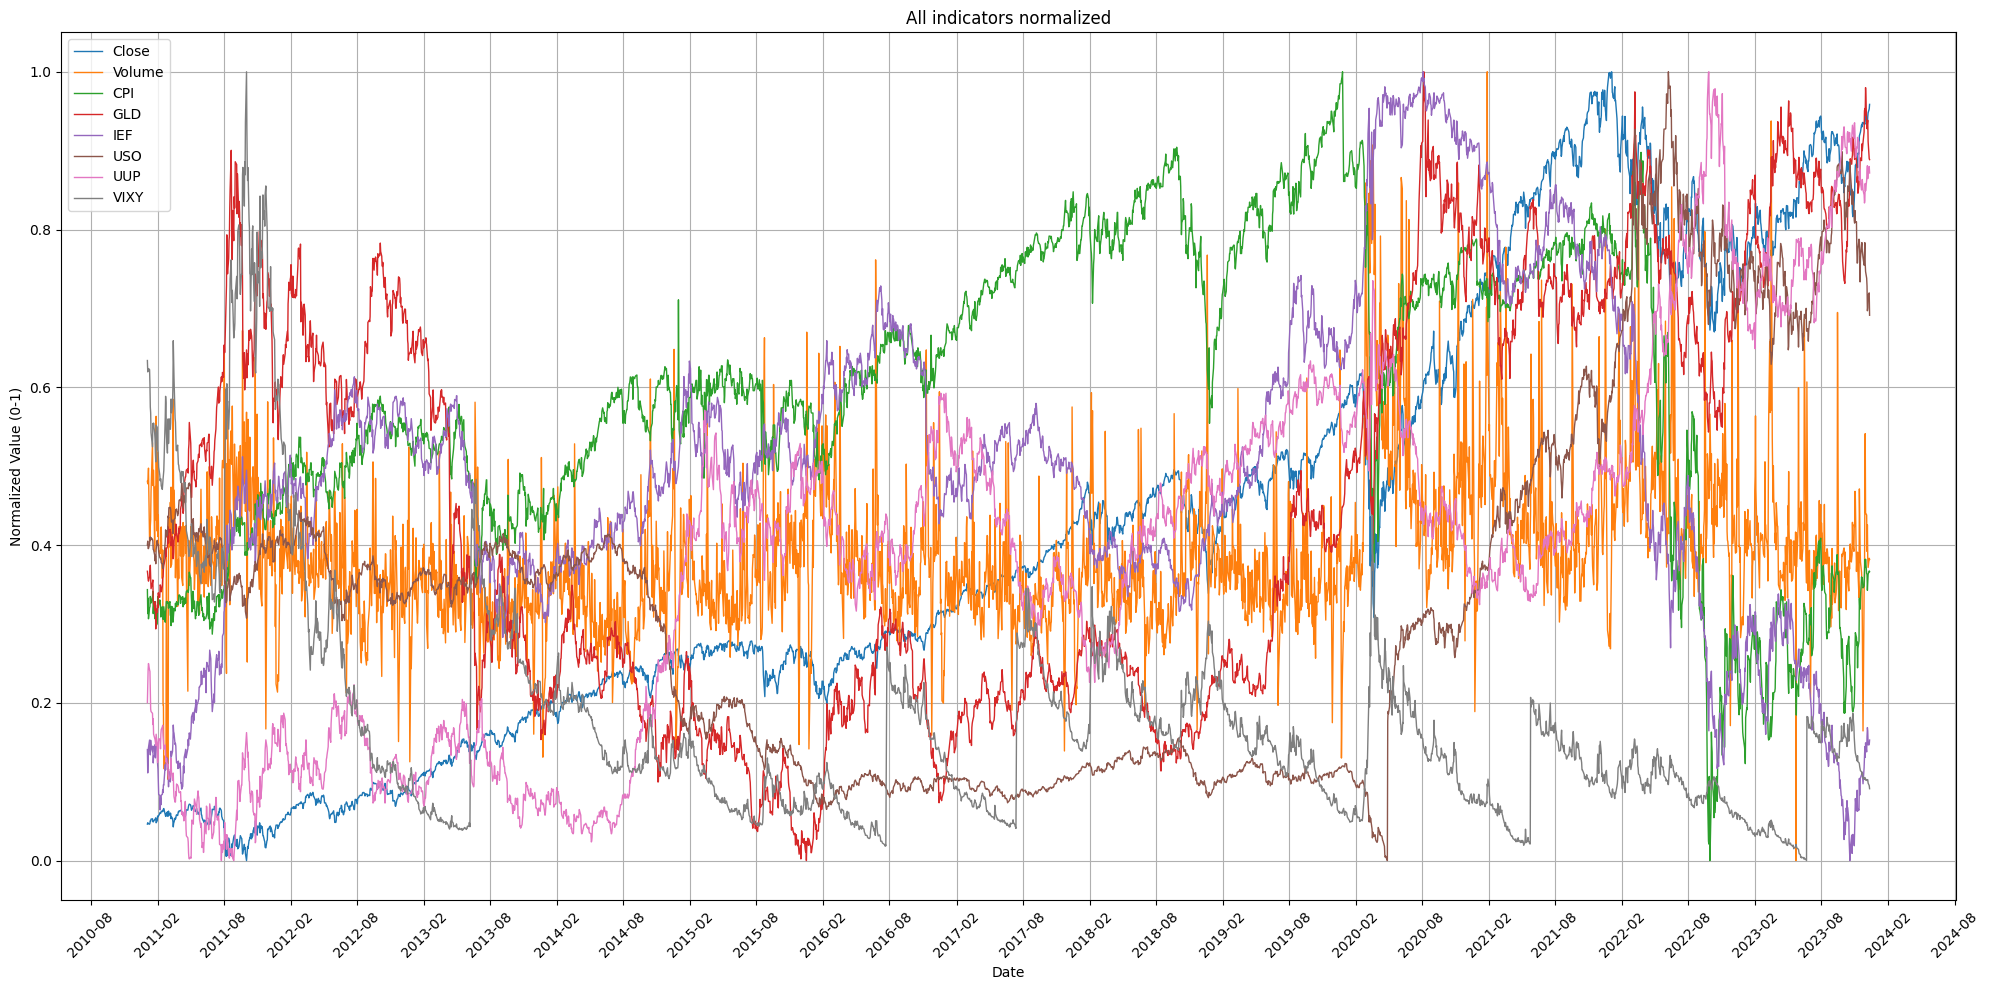

In [127]:
cols = ['Close', 'Volume', 'CPI', 'GLD', 'IEF', 'USO', 'UUP', 'VIXY']

scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(data[cols]),
                               columns=cols,
                               index=data.index)

plt.figure(figsize=(20,10))

for col in cols:
    plt.plot(normalized_data.index, normalized_data[col], label=col, linewidth=1)

plt.xlabel("Date")
plt.ylabel("Normalized Value (0-1)")
plt.title("All indicators normalized")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

line_path = os.path.join(FIG_DIR, "line_all_normalized.png")
plt.savefig(line_path, dpi=150)
plt.show()
plt.close()

### c.5. Heatmap

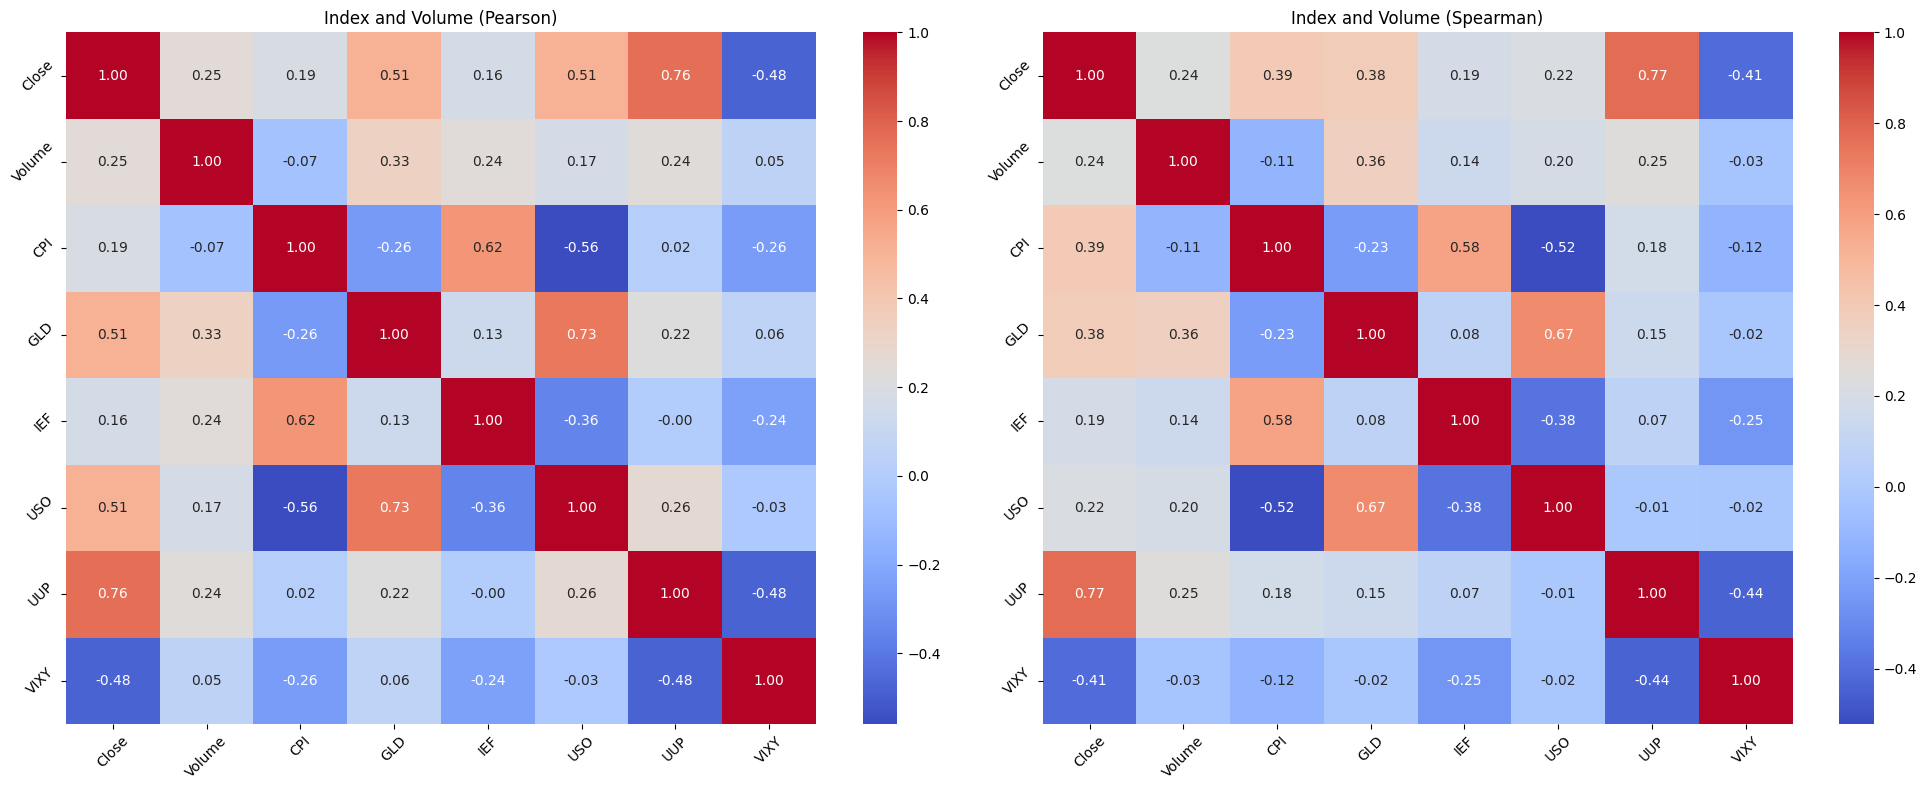

In [128]:
corr_pear = data[['Close', 'Volume', 'CPI', 'GLD', 'IEF', 'USO', 'UUP', 'VIXY']
].corr(method="pearson")

corr_spear = data[['Close', 'Volume', 'CPI', 'GLD', 'IEF', 'USO', 'UUP', 'VIXY']
].corr(method="spearman")

plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.heatmap(corr_pear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.xticks(rotation=(45))
plt.title("Index and Volume (Pearson)")

plt.subplot(1, 2, 2)
sns.heatmap(corr_spear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.xticks(rotation=(45))
plt.title("Index and Volume (Spearman)")

plt.tight_layout()
plt.show()

## d. Anomaly detection

In [129]:
def detect_outliers_zscore(df, cols=None, z_thresh=3.0):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    out = pd.DataFrame(False, index=df.index, columns=cols)
    for c in cols:
        vals = df[c].values
        z = np.abs(stats.zscore(vals, nan_policy='omit'))
        mask = np.zeros_like(z, dtype=bool)
        mask[~np.isnan(z)] = z[~np.isnan(z)] > z_thresh
        out[c] = mask
    return out

def detect_outliers_iqr(df, cols=None, k=1.5):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    out = pd.DataFrame(False, index=df.index, columns=cols)
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        out[c] = (df[c] < lower) | (df[c] > upper)
    return out

In [130]:
def detect_outliers_rolling(df, col='Close', window=20, z_thresh=3.0, min_periods=None):
    if min_periods is None:
        min_periods = max(3, window//2)
    roll_mean = df[col].rolling(window=window, min_periods=min_periods, center=False).mean()
    roll_std  = df[col].rolling(window=window, min_periods=min_periods, center=False).std()
    z = (df[col] - roll_mean) / (roll_std + 1e-12)
    mask = z.abs() > z_thresh
    res = pd.Series(False, index=df.index, name=f'rolling_{col}')
    res[mask.fillna(False)] = True
    return res, roll_mean, roll_std

In [131]:
def detect_outliers_decompose(df, col='Close', model='additive', period=None, z_thresh=3.0):
    if period is None:
        period = 252 if df.shape[0] > 300 else None

    if period is None:
        raise ValueError("Need to pass period for seasonal_decompose with short window. E.g.: period=7,30,252 ...")

    decomp = seasonal_decompose(df[col].dropna(), model=model, period=period, extrapolate_trend='freq')
    resid = decomp.resid.reindex(df.index)  # align
    z = (resid - resid.mean()) / (resid.std(ddof=0) + 1e-12)
    mask = z.abs() > z_thresh
    return mask.fillna(False), decomp


In [132]:
def detect_outliers_arima_residuals(df, col='Close', order=(1,1,1), z_thresh=3.0, enforce_stationarity=False, enforce_invertibility=False):
    series = df[col].dropna()
    try:
        model = ARIMA(series, order=order, enforce_stationarity=enforce_stationarity, enforce_invertibility=enforce_invertibility)
        res = model.fit()
        resid = res.resid.reindex(df.index)
        z = (resid - resid.mean()) / (resid.std(ddof=0) + 1e-12)
        mask = z.abs() > z_thresh
        return mask.fillna(False), res
    except Exception as e:
        print("ARIMA fitting failed:", e)
        return pd.Series(False, index=df.index), None


In [133]:
def detect_outliers_isolationforest(df, feature_cols=None, contamination=0.01, random_state=42):
    if feature_cols is None:
        feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    X = df[feature_cols].copy()
    X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)
    sc = StandardScaler()
    Xs = sc.fit_transform(X)
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    iso.fit(Xs)
    preds = iso.predict(Xs)
    mask = pd.Series(preds == -1, index=df.index)
    scores = pd.Series(iso.decision_function(Xs), index=df.index)
    return mask, scores


In [134]:
def aggregate_outliers(df, methods_dict):
    out_df = pd.DataFrame(index=df.index)
    for name, mask in methods_dict.items():
        out_df[name] = mask.astype(bool)
    out_df['any_outlier'] = out_df.any(axis=1)
    out_df['n_methods_flagged'] = out_df.drop(columns=['any_outlier']).sum(axis=1)
    return out_df


In [135]:
def plot_time_series_with_flags(df, col='Close', agg_flags=None, title=None, figsize=(20,6)):
    plt.figure(figsize=figsize)
    plt.plot(df.index, df[col], label=col, color='blue', linewidth=1)

    if agg_flags is not None and 'n_methods_flagged' in agg_flags.columns:
        flagged_pts = df.loc[agg_flags['n_methods_flagged'] > 0, col]
        n_flags = agg_flags.loc[agg_flags['n_methods_flagged'] > 0, 'n_methods_flagged']

        sizes = n_flags * 100
        alphas = np.clip(n_flags / n_flags.max(), 0.1, 1.2)

        for i, idx in enumerate(flagged_pts.index):
            plt.scatter(idx, flagged_pts.iloc[i], 
                        s=sizes.iloc[i], 
                        color='red', 
                        alpha=alphas.iloc[i], 
                        edgecolors='k', 
                        linewidths=0.5)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title(title or f"{col} with outliers")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [142]:
ano_data = data.copy()

numeric_cols = ano_data.select_dtypes(include=[np.number]).columns.tolist()
zflags = detect_outliers_zscore(ano_data, cols=numeric_cols, z_thresh=3.0)
iqrflags = detect_outliers_iqr(ano_data, cols=numeric_cols, k=1.5)
roll_mask, roll_mean, roll_std = detect_outliers_rolling(ano_data, col='Close', window=20, z_thresh=3.0)

try:
    decomp_mask, decomp = detect_outliers_decompose(ano_data, col='Close', model='additive', period=252, z_thresh=3.0)
except ValueError:
    decomp_mask = pd.Series(False, index=ano_data.index)

arima_mask, arima_res = detect_outliers_arima_residuals(ano_data, col='Close', order=(1,1,1), z_thresh=3.5)

iso_mask, iso_scores = detect_outliers_isolationforest(ano_data, feature_cols=numeric_cols, contamination=0.01)

methods_close = {
    'z_close': zflags['Close'],
    'iqr_close': iqrflags['Close'],
    'rolling_close': roll_mask,
    'decomp_close': decomp_mask,
    'arima_close': arima_mask,
    'iso_multivariate': iso_mask
}
agg_close = aggregate_outliers(ano_data, methods_close)

methods_cols = {}
for c in numeric_cols:
    methods_cols[f'{c}_z'] = zflags[c]
    methods_cols[f'{c}_iqr'] = iqrflags[c]
agg_all = aggregate_outliers(ano_data, methods_cols)

print("Top Close anomalies (any method):")
print(agg_close[agg_close['any_outlier']].sort_values('n_methods_flagged', ascending=False).head(20))

/home/nguyen-quang-huy/GITHUB/My Repo/sp500-40-data-visualization-and-analytics/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/nguyen-quang-huy/GITHUB/My Repo/sp500-40-data-visualization-and-analytics/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/nguyen-quang-huy/GITHUB/My Repo/sp500-40-data-visualization-and-analytics/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/tmp/ipykernel_16457/3125464411.py:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise i

Top Close anomalies (any method):
            z_close  iqr_close  rolling_close  decomp_close  arima_close  \
Date                                                                       
2020-03-26    False      False          False          True         True   
2020-03-16    False      False          False          True         True   
2020-03-12    False      False          False          True         True   
2020-03-24    False      False          False          True         True   
2020-03-17    False      False          False          True        False   
2020-03-20    False      False          False          True        False   
2023-12-12    False      False          False          True        False   
2020-03-31    False      False          False          True        False   
2020-04-01    False      False          False          True        False   
2020-04-02    False      False          False          True        False   
2020-04-03    False      False          False         

In [138]:
agg_close.columns

Index(['z_close', 'iqr_close', 'rolling_close', 'decomp_close', 'arima_close',
       'iso_multivariate', 'any_outlier', 'n_methods_flagged'],
      dtype='object')

In [143]:
ano_data = ano_data.copy()
ano_data = ano_data.join(agg_close[['z_close', 'iqr_close', 'rolling_close', 'decomp_close', 'arima_close',
       'iso_multivariate', 'any_outlier', 'n_methods_flagged']])
ano_data.head()
ano_data.to_csv("data/outlier_annotated.csv")

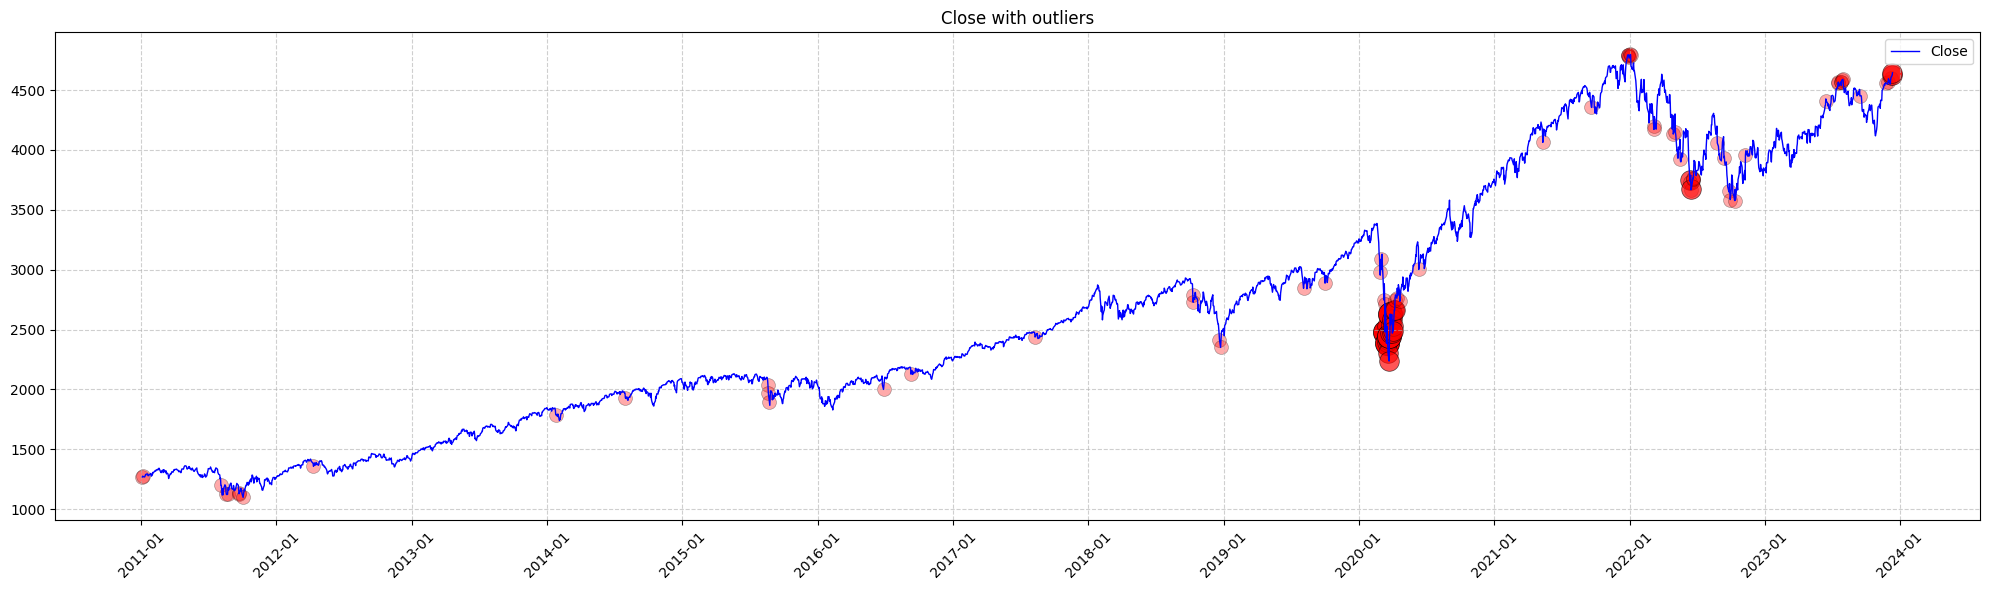

In [144]:
plot_time_series_with_flags(ano_data, col='Close', agg_flags=agg_close)

# **2. Probability distribution analysis**

# **3. Hypothesis Testing**

# **4. Correlation Analysis**

# **5. Multiple Linear Regression**